In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("student_mat_cleaned.csv")
df.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False


In [2]:
X = df.drop("G3", axis=1)
y = df["G3"]


In [3]:
X = pd.get_dummies(X, drop_first=True)
X.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False


In [4]:
#method1 correlation analysis
corr = pd.concat([X, y], axis=1).corr()

corr_target = corr["G3"].drop("G3").sort_values(ascending=False)
print("Correlation with G3:\n")
print(corr_target.head(15))


Correlation with G3:

G2                   0.904868
G1                   0.801468
Medu                 0.217147
higher_yes           0.182465
Fedu                 0.152457
Mjob_health          0.116158
address_U            0.105756
sex_M                0.103456
paid_yes             0.101996
internet_yes         0.098483
studytime            0.097820
reason_reputation    0.095692
Fjob_teacher         0.095374
famsize_LE3          0.081407
Mjob_services        0.078429
Name: G3, dtype: float64


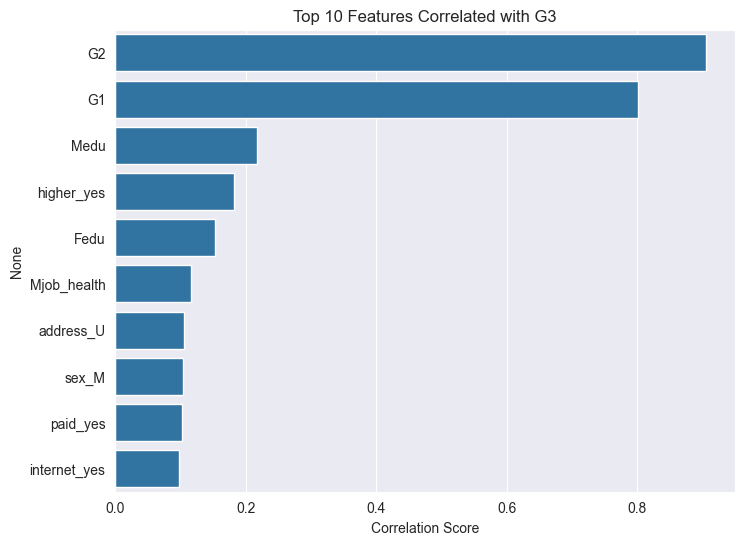

In [5]:
#plot top 10 correlated features
plt.figure(figsize=(8,6))
sns.barplot(x=corr_target.head(10), y=corr_target.head(10).index)
plt.title("Top 10 Features Correlated with G3")
plt.xlabel("Correlation Score")
plt.show()


In [6]:
#method 2 selectKBest
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X, y)

scores = selector.scores_
columns = X.columns

skb_scores = pd.DataFrame({
    "Feature": columns,
    "Score": scores
}).sort_values(by="Score", ascending=False)

print("Top SelectKBest Features:")
print(skb_scores.head(10))


Top SelectKBest Features:
         Feature        Score
14            G2  1775.707546
13            G1   705.842247
5       failures    58.671666
1           Medu    19.448184
38    higher_yes    13.534903
0            age    10.535470
2           Fedu     9.351913
8          goout     7.054389
40  romantic_yes     6.752698
3     traveltime     5.467880


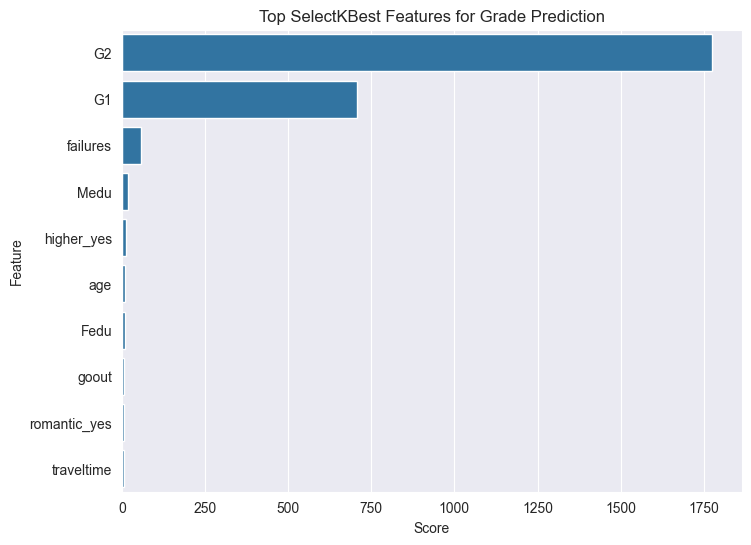

In [7]:
#plot selectKbest scores
plt.figure(figsize=(8,6))
sns.barplot(data=skb_scores.head(10), x="Score", y="Feature")
plt.title("Top SelectKBest Features for Grade Prediction")
plt.show()


In [9]:
#method3 LASSO regression feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)
lasso_coeff = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso.coef_
})

lasso_selected = lasso_coeff[lasso_coeff["Coefficient"] != 0]
print("LASSO Selected Features:")
print(lasso_selected)


LASSO Selected Features:
          Feature  Coefficient
0             age    -0.057448
5        failures    -0.046976
6          famrel     0.143334
12       absences     0.151039
13             G1     0.412448
14             G2     3.613747
26  Fjob_services    -0.015736
40   romantic_yes    -0.019379


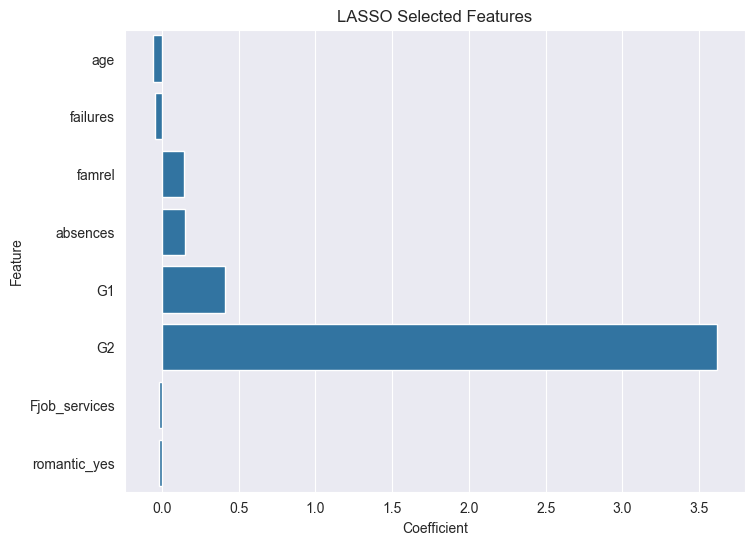

In [10]:
#plot LASSO coefficients
plt.figure(figsize=(8,6))
sns.barplot(data=lasso_selected, x="Coefficient", y="Feature")
plt.title("LASSO Selected Features")
plt.show()


In [11]:
#choose features that show up in atleast two methods
top_corr_feats = set(corr_target.head(15).index)
top_skb_feats = set(skb_scores.head(15)["Feature"])
lasso_feats = set(lasso_selected["Feature"])

# Features selected by at least 2 methods
final_features = list((top_corr_feats & top_skb_feats) |
                      (top_corr_feats & lasso_feats) |
                      (top_skb_feats & lasso_feats))

print("FINAL SELECTED FEATURES:")
print(final_features)


FINAL SELECTED FEATURES:
['Fedu', 'age', 'sex_M', 'address_U', 'higher_yes', 'G1', 'Mjob_health', 'paid_yes', 'internet_yes', 'romantic_yes', 'failures', 'Medu', 'G2']


In [12]:
pd.DataFrame(final_features, columns=["Selected_Features"]).to_csv("final_selected_features.csv", index=False)


In [13]:
import os

for f in os.listdir():
    print(f)


.idea
.venv
feature_selection.ipynb
final_selected_features.csv
student-mat.csv
student_mat_cleaned.csv
student_perf.py
student_perf_project.ipynb
